This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the real dataset (cme)
- the set `.env` at the root with `$WORKSPACE` and `$DEMAPPER`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of DeMapper configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_cme_clust1.json cme

```


## Step 2) Analyze the created Mappers graphs (delay times, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the delay times criteria and the other statistics:


```
CONF=mappers_cme_clust1.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
DATAFOLDER="$WORKSPACE/results/cme/${CONF}/"
FN_TIMING="$WORKSPACE/data/cme/timing.csv"
OUTPUT_DIR="$WORKSPACE/results/cme/analysis/${CONF}/"
STAT_TYPE="compute_degrees_from_TCM"
CHANGE_POINTS=10
HAS_INSTRUCTIONS=1;
ARGS="datafolder='${DATAFOLDER}'; fn_timing='${FN_TIMING}'; output_dir='${OUTPUT_DIR}'; stat_type='${STAT_TYPE}';"
ARGS="$ARGS HAS_INSTRUCTIONS=${HAS_INSTRUCTIONS}; CHANGE_POINTS=${CHANGE_POINTS};"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/cme/deg_analysis_sbjs.m')"
```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/cme/shine/cohort.csv \
    $WORKSPACE/results/cme/${CONF}/ \
    --output_dir $WORKSPACE/results/cme/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [4]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image
from scipy.stats import f_oneway

sns.set(rc={'figure.facecolor':'white'})

# demapper imports for the analysis
from code.utils.analyze import extract_dataset, _handle_list_cols
from code.utils.config_cme import DATASETS, FILTERS
from code.utils.config_mapper import extract_params_f
from code.utils.plot_grids import plot_grid_params
from code.utils.utils import filter_dataframe, count_passing, add_col_passing

### Figure (a)

In [19]:
import random
from scipy import stats


sns.set(font_scale=1.5)
sns.set_style(style='white')

PICKED_DATASET = 'cme-clust1'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, 'compute_degrees_from_TCM/combined-compute_degrees_from_TCM.csv')

filter_by = None
df_link, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][0], extract_params_f, has_sbj=False)
df_dbscan, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][1], extract_params_f, has_sbj=False)
df_link['name'] = df_link.apply(lambda row: 'Linkage_bins={}'.format(row['linkbins']), axis=1)
df_dbscan['name'] = df_dbscan.apply(lambda row: 'DBSCAN_Eps={}'.format(row['clustEps']), axis=1)

target_metrics_limits = {
    'ChangePointsIndicesError': [0, 12],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}

df = pd.concat([df_link, df_dbscan])

resdir = datadir

df.sample(5)

len(stats):  2000
len(results):  2000
len(stats):  2000
len(results):  2000


,Mapper,K,R,G,linkbins,ChangePointsIndicesError,ChangePointsCount,assortativity-mean,assortativity-std,coverage_TRs-mean,...,degree_TRs_entropy-mean,degree_TRs_entropy-std,distances_entropy-mean,distances_entropy-std,distances_max-mean,distances_max-std,hrfdur_stat-mean,hrfdur_stat-std,name,clustEps
1582,ClustLinkBDLMapper_4_30_30_20,4,30,30,20.0,21.714286,10.0,0.110940,0.123161,0.712444,...,4.391283,0.310478,4.616798,0.482592,35.944444,13.166232,0.257002,0.154908,Linkage_bins=20,NaN
1328,ClustLinkBDLMapper_32_15_50_10,32,15,50,10.0,9.285714,10.0,-0.183431,0.070007,0.957173,...,5.247194,0.569049,3.670074,0.204876,20.722222,4.687977,0.152972,0.047015,Linkage_bins=10,NaN
222,ClustDBSCANBDLMapper_24_15_30_4,24,15,30,NaN,5.000000,10.0,0.285015,0.151421,0.841473,...,4.160951,0.259579,3.394743,0.288065,13.500000,2.595245,0.435344,0.176861,DBSCAN_Eps=4,4.0
1142,ClustLinkBDLMapper_16_20_30_20,16,20,30,20.0,5.714286,10.0,-0.096694,0.103871,0.586584,...,4.893452,0.601211,3.072767,0.244876,14.388889,2.304443,0.063600,0.014348,Linkage_bins=20,NaN
84,ClustDBSCANBDLMapper_12_30_40_16,12,30,40,NaN,7.714286,10.0,0.412073,0.080945,0.874358,...,3.987424,0.286000,4.158758,0.276981,24.333333,5.258047,0.494652,0.078124,DBSCAN_Eps=16,16.0


In [20]:

clusts = df['name'].drop_duplicates().to_numpy()
Kvals = df['K'].drop_duplicates().to_numpy()

table = []
for clust in clusts:
    for k in sorted(Kvals):
        fdf = filter_dataframe(df, { 'name': [clust], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'clust': clust,
            'method': clust[:6] if 'DBSCAN' in clust else clust[:7],
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
        })


counts_df = pd.DataFrame(data=table)

print('max in counts_df:', counts_df['count'].max())


max in counts_df: 22


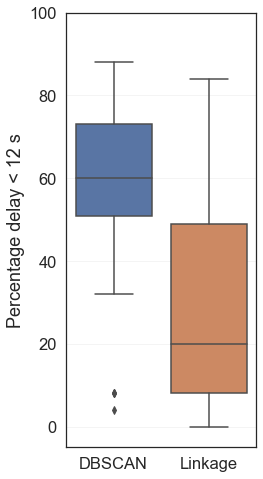

In [42]:
plt.figure(figsize=(4,7))

sns.boxplot(data=counts_df, x='method', y='perc', order=['DBSCAN', 'Linkage'])
plt.xlabel('')
plt.ylabel('Percentage delay < 12 s')
plt.grid(axis='y', alpha=0.2)
plt.ylim([-5,100])
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'clust_methods.png')
plt.savefig(save_path, dpi=300)

In [43]:
X_link = counts_df[counts_df['method'] == 'Linkage']['count'].to_numpy()
X_dbscan = counts_df[counts_df['method'] == 'DBSCAN']['count'].to_numpy()
# assert len(X_dbscan) == len(X_link)
stats.ttest_ind(X_link, X_dbscan)

Ttest_indResult(statistic=-5.198073587873185, pvalue=1.573594567899296e-06)

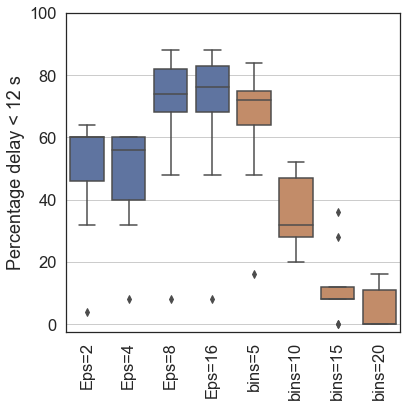

In [45]:
counts_df['name'] = counts_df.apply(lambda row: row['clust'].replace('Linkage_', '').replace('DBSCAN_', ''), axis=1)

clust_order = [
 'Eps=2',
 'Eps=4',
 'Eps=8',
 'Eps=16',
 'bins=5',
 'bins=10',
 'bins=15',
 'bins=20',]

cols = (['#5F74A0'] * 4) + (['#C28C69'] * 4)

# WS1
cdf = counts_df.sort_values(by='order')
plt.figure(figsize=(6,6))
ax = sns.boxplot(data=cdf, x='name', y='perc', order=clust_order, palette=cols, saturation=1.0) # , color='green'
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.xlabel('')
plt.ylabel('Percentage delay < 12 s')
plt.grid(axis='y')
plt.ylim([-2.5, 100.0])
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.title('Count of correct mapper graphs')
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'perf_clusts.png')
plt.savefig(save_path, dpi=300)

In [62]:
# one way ANOVA for DBSCAN and Linkage
ldf = counts_df[counts_df['method'] == 'Linkage']
buckets = ldf['clust'].drop_duplicates().tolist()
print('Linkage', f_oneway(*[ldf[ldf['clust'] == b]['perc'].tolist() for b in buckets]))

ddf = counts_df[counts_df['method'] == 'DBSCAN']
buckets = ddf['clust'].drop_duplicates().tolist()
print('DBSCAN', f_oneway(*[ddf[ddf['clust'] == b]['perc'].tolist() for b in buckets]))

Linkage F_onewayResult(statistic=39.62675714978191, pvalue=1.692266634867536e-11)
DBSCAN F_onewayResult(statistic=2.700641898463334, pvalue=0.06002191207498937)


In [65]:
r1 = counts_df[counts_df['clust'] == 'Linkage_bins=5']['perc'].tolist()
r2 = counts_df[counts_df['clust'] == 'DBSCAN_Eps=16']['perc'].tolist()
stats.ttest_ind(r1, r2)

Ttest_indResult(statistic=-0.3619354978199995, pvalue=0.721614342542614)